In [1]:
import numpy as np
from lab3_tools import *
from lab3_proto import *
from tqdm import tqdm
import os
import keras
from matplotlib.pyplot import plot as tplt
import warnings
warnings.filterwarnings('ignore')



%pylab inline
pylab.rcParams['figure.figsize'] = (15, 4)

## Import scripts from lab1
import sys
sys.path.insert(1, '../Lab1/')
from lab1_proto import*

## Import scripts from lab2
import sys
sys.path.insert(1, '../Lab2/')
from lab2_proto import*
from prondict import*

## Auto-reloading
%load_ext autoreload
%autoreload 2


Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load parameters
phoneHMMs_all = np.load('../Lab2/lab2_models_all.npz',allow_pickle=True)['phoneHMMs'].item()
# phoneHMMs_one = load('../Lab2/lab2_models_onespkr.npz',allow_pickle=True)['phoneHMMs'].item()
print("phoneme HMM models:")
phones = sorted(phoneHMMs_all.keys())
print(list(phones))
print(phoneHMMs_all['sp'].keys())

# Pronaunciation dictionary
print()
print("============")
print("The pronancuation dictionary:")
prondict

phoneme HMM models:
['ah', 'ao', 'ay', 'eh', 'ey', 'f', 'ih', 'iy', 'k', 'n', 'ow', 'r', 's', 'sil', 'sp', 't', 'th', 'uw', 'v', 'w', 'z']
dict_keys(['name', 'startprob', 'transmat', 'means', 'covars'])

The pronancuation dictionary:


{'o': ['ow'],
 'z': ['z', 'iy', 'r', 'ow'],
 '1': ['w', 'ah', 'n'],
 '2': ['t', 'uw'],
 '3': ['th', 'r', 'iy'],
 '4': ['f', 'ao', 'r'],
 '5': ['f', 'ay', 'v'],
 '6': ['s', 'ih', 'k', 's'],
 '7': ['s', 'eh', 'v', 'ah', 'n'],
 '8': ['ey', 't'],
 '9': ['n', 'ay', 'n']}

In [3]:
# Load example data
example = load('lab3_example.npz',allow_pickle=True)['example'].item()
example.keys()

dict_keys(['filename', 'samples', 'gender', 'speaker', 'digits', 'repetition', 'lmfcc', 'wordTrans', 'phoneTrans', 'utteranceHMM', 'stateTrans', 'obsloglik', 'viterbiLoglik', 'viterbiPath', 'viterbiStateTrans'])

In [4]:
import pickle

## Load models
phoneHMMs_all = np.load('../Lab2/lab2_models_all.npz',allow_pickle=True)['phoneHMMs'].item()
phones = sorted(phoneHMMs_all.keys())

# all possible phones and the nr of their states(phone:nr of states)
nstates = {phone: phoneHMMs_all[phone]['means'].shape[0] for phone in phones}
# list of all states(3 states for each phone)
stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]

# Saving the objects:
#pickle.dump([nstates, stateList, phones], open('saved_files/phoneHMM_states.pkl', 'wb'))

# Getting back the objects:
# nstates, stateList, phones = pickle.load( open('saved_files/phoneHMM_states.pkl', 'rb'))

In [5]:
# My functions deliver the same outputs as excpected from example
filename = '../datasets/tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'
samples, samplingrate = loadAudio(filename)
print(np.allclose(example['samples'], samples))
lmfcc = mfcc(samples)
print(np.allclose(example['lmfcc'], lmfcc)) #!!
wordTrans = list(path2info(filename)[2])
print(example['wordTrans'] == wordTrans)

True
True
True


###  List of concatenated phones for word

In [8]:
phoneTrans = words2phones(wordTrans, prondict)
print(example['phoneTrans']== phoneTrans)
stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]
print(example['stateTrans'] == stateTrans)
print(phoneTrans)

True
True
['sil', 'z', 'iy', 'r', 'ow', 'sp', 'f', 'ao', 'r', 'sp', 'th', 'r', 'iy', 'sp', 'sil']


In [9]:
utteranceHMM = concatHMMs(phoneHMMs_all, phoneTrans)

# Check that means, covar and startprob of concatened HMM are the same as in example
for i in example['utteranceHMM'].keys():
    print(np.allclose(utteranceHMM[i], example['utteranceHMM'][i]))
    
print("Number of states for the concatenated HMM of the example (0f3):", utteranceHMM['means'].shape[0])

True
True
True
True
Number of states for the concatenated HMM of the example (0f3): 39


## Viterbi

Correct obsloglik: True
Correct viterbi: True


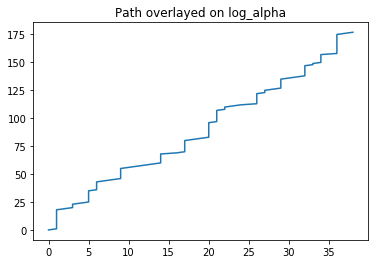

In [9]:
obsloglik = log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars'])
viterbi_loglik, viterbi_path = viterbi(obsloglik, np.log(utteranceHMM['startprob']), np.log(utteranceHMM['transmat']), True)
plt.plot(viterbi_path, np.arange(len(viterbi_path)))
plt.title("Path overlayed on log_alpha")
print("Correct obsloglik:",np.allclose(obsloglik, example['obsloglik']))
print("Correct viterbi:",np.allclose(viterbi_path, example['viterbiPath']))

In [10]:
viterbiStateTrans = list(np.array(stateTrans)[viterbi_path,])
print("Correct viterbi path state trans:", viterbiStateTrans ==  example['viterbiStateTrans'])

print("\nPath of states:",viterbiStateTrans)
targets = [stateList.index(k) for k in list(np.array(stateTrans)[viterbi_path,])]
print("\nPath of targets(indexes):",targets)

Correct viterbi path state trans: True

Path of states: ['sil_0', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_2', 'z_0', 'z_0', 'z_0', 'z_0', 'z_1', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_1', 'iy_2', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_1', 'r_2', 'ow_0', 'ow_1', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'f_0', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_2', 'ao_0', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'r_0', 'r_0', 'r_0', 'r_1', 'r_2', 'th_0', 'th_0', 'th_0', 'th_0', 'th_0', 'th_0', 'th_0', 'th_0', '

In [11]:
_=frames2trans(viterbiStateTrans,outfilename='z43a.lab')# save the path states in file format that can be used in wavesurfer

# Feature Extraction

### Extract training and test data

In [50]:
!python3  Lab3_load_training_and_test_set.py

Nr of words in training set: 8623
Nr of words in testing set: 8700
Nr of timesteps for train data: 1507057
Nr of timesteps for test data: 1526682


# 4) Concatinating HMMs

## Train-Valid Split

In [51]:
!python3 Lab3_split_train_valid.py

0.9000347906760988 0.0999652093239012
Trainign set: Women-> 3956 , Men-> 3805
Validation set: Women-> 432 , Men-> 430


## Create Dynamic Features

In [3]:
print("DYNAMIC FEATURES")
!python3 Lab3_create_dynamic_features.py

print("\nNON DYNAMIC FEATURES")
!python3 Lab3_create_non_dynamic_features.py

DYNAMIC FEATURES
Training set has 1357194 lmfcc_x samples with dimension  91 .
Training set has 1357194 mspec_x samples with dimension  280 .
Test set has 1526682 lmfcc_x samples with dimension  91 .
Test set has 1526682 mspec_x samples with dimension  280 .
Validation set has 149863 lmfcc_x samples with dimension  91 .
Validation set has 149863 mspec_x samples with dimension  280 .

NON DYNAMIC FEATURES
Training set has 1357194 lmfcc_x samples with dimension  13 .
Training set has 1357194 mspec_x samples with dimension  40 .
Test set has 1526682 lmfcc_x samples with dimension  13 .
Test set has 1526682 mspec_x samples with dimension  40 .
Validation set has 149863 lmfcc_x samples with dimension  13 .
Validation set has 149863 mspec_x samples with dimension  40 .


## Normalizing and one-hot encoding of targets(for dynamic and nondynamic features)

In [48]:
!python3 Lab3_normalize_dynamic.py
!python3 Lab3_normalize_non_dynamic.py

# Phoneme Recognition with Deep Neural Networks

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix


nstates, stateList, phones = pickle.load( open('saved_files/phoneHMM_states.pkl', 'rb'))

## 1) Dynamic Lmfcc as features 

In [16]:
X = None; Y=None; X_val = None; Y_val = None; X_test = None; Y_test = None

# Load data
with np.load('datas/lmfcc_train_x_reg.npz', allow_pickle=True) as data:
    X = data['lmfcc_x']
    Y = data['targets']
with np.load('datas/lmfcc_val_x_reg.npz', allow_pickle=True) as data:
    X_val = data['lmfcc_x']
    Y_val = data['targets']
with np.load('datas/lmfcc_test_x_reg.npz', allow_pickle=True) as data:
    X_test = data['lmfcc_x']
    Y_test = data['targets']

### Rmsprop

In [33]:
model = Sequential()
model.add(Dense(256, input_shape=(X.shape[1],), activation='relu') )
model.add(Dense(256, activation='relu'))
model.add(Dense(Y.shape[1], activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X, Y, epochs=5, batch_size=256, validation_data = (X_val, Y_val))

model.save("nets/lmfcc_dyn_recognizer_rmsprop.h5")

Train on 1357194 samples, validate on 149863 samples
Epoch 1/5
1357194/1357194 [==============================] - 27s 20us/step - loss: 0.8361 - accuracy: 0.7280 - val_loss: 0.7576 - val_accuracy: 0.7472
Epoch 2/5
1357194/1357194 [==============================] - 28s 20us/step - loss: 0.6615 - accuracy: 0.7785 - val_loss: 0.6863 - val_accuracy: 0.7748
Epoch 3/5
1357194/1357194 [==============================] - 28s 20us/step - loss: 0.6131 - accuracy: 0.7935 - val_loss: 0.6586 - val_accuracy: 0.7863
Epoch 4/5
1357194/1357194 [==============================] - 28s 21us/step - loss: 0.5948 - accuracy: 0.8004 - val_loss: 0.6560 - val_accuracy: 0.7890
Epoch 5/5
1357194/1357194 [==============================] - 28s 20us/step - loss: 0.5885 - accuracy: 0.8029 - val_loss: 0.6601 - val_accuracy: 0.7868


1526682/1526682 [==============================] - 16s 11us/step
accuracy: 75.72%

Confusion Matrix


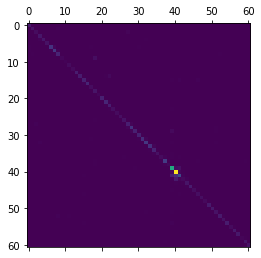

In [13]:
model = load_model("nets/lmfcc_dyn_recognizer_rmsprop.h5")
score = model.evaluate(X_test, Y_test, batch_size=128)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Y_pred = model.predict(X_test)

print('\nConfusion Matrix')
plt.matshow(confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)))
plt.show()

# print('Classification Report')
# print(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names=stateList))

### Adam

In [35]:
model = Sequential()
model.add(Dense(256, input_shape=(X.shape[1],), activation='relu') )
model.add(Dense(256, activation='relu'))
model.add(Dense(Y.shape[1], activation='sigmoid'))
opt = keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X, Y, epochs=15, batch_size=256, validation_data = (X_val, Y_val))

model.save("nets/lmfcc_dyn_recognizer_adam.h5")

Train on 1357194 samples, validate on 149863 samples
Epoch 1/15
1357194/1357194 [==============================] - 28s 21us/step - loss: 0.8523 - accuracy: 0.7251 - val_loss: 0.7397 - val_accuracy: 0.7593
Epoch 2/15
1357194/1357194 [==============================] - 28s 21us/step - loss: 0.6818 - accuracy: 0.7731 - val_loss: 0.6951 - val_accuracy: 0.7721
Epoch 3/15
1357194/1357194 [==============================] - 28s 21us/step - loss: 0.6330 - accuracy: 0.7871 - val_loss: 0.6562 - val_accuracy: 0.7836
Epoch 4/15
1357194/1357194 [==============================] - 28s 21us/step - loss: 0.6009 - accuracy: 0.7959 - val_loss: 0.6569 - val_accuracy: 0.7835
Epoch 5/15
1357194/1357194 [==============================] - 28s 21us/step - loss: 0.5727 - accuracy: 0.8052 - val_loss: 0.6241 - val_accuracy: 0.7934
Epoch 6/15
1357194/1357194 [==============================] - 29s 21us/step - loss: 0.5537 - accuracy: 0.8115 - val_loss: 0.6075 - val_accuracy: 0.8003
Epoch 7/15
1357194/1357194 [=======

1526682/1526682 [==============================] - 18s 12us/step
accuracy: 77.55%

Confusion Matrix


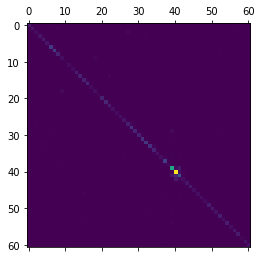

Classification Report
              precision    recall  f1-score   support

        ah_0       0.77      0.70      0.73     18732
        ah_1       0.73      0.70      0.72     15513
        ah_2       0.68      0.53      0.60     11269
        ao_0       0.84      0.74      0.79     14732
        ao_1       0.78      0.86      0.82     16593
        ao_2       0.79      0.85      0.82     12841
        ay_0       0.83      0.86      0.85     38703
        ay_1       0.85      0.89      0.87     37216
        ay_2       0.75      0.75      0.75     26225
        eh_0       0.51      0.59      0.55     11809
        eh_1       0.85      0.70      0.77      3333
        eh_2       0.78      0.77      0.78      7243
        ey_0       0.61      0.64      0.62      9276
        ey_1       0.81      0.86      0.83     19208
        ey_2       0.86      0.79      0.82     23634
         f_0       0.74      0.71      0.72     25993
         f_1       0.83      0.93      0.88     24580
     

In [17]:
model = load_model("nets/lmfcc_dyn_recognizer_adam.h5")
score = model.evaluate(X_test, Y_test, batch_size=128)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
Y_pred = model.predict(X_test)
save_predictions(Y_test, Y_pred, 'lmfcc_dyn')
print('\nConfusion Matrix')
plt.matshow(confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)))
plt.show()
print('Classification Report')
print(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names=stateList))

## 2) Dynamic Mspec as features

In [11]:
X = None; Y=None; X_val = None; Y_val = None; X_test = None; Y_test = None

# Load data
with np.load('datas/mspec_train_x_reg.npz', allow_pickle=True) as data:
    X = data['mspec_x']
    Y = data['targets']
with np.load('datas/mspec_val_x_reg.npz', allow_pickle=True) as data:
    X_val = data['mspec_x']
    Y_val = data['targets']
with np.load('datas/mspec_test_x_reg.npz', allow_pickle=True) as data:
    X_test = data['mspec_x']
    Y_test = data['targets']

In [40]:
model = Sequential()
model.add(Dense(256, input_shape=(X.shape[1],), activation='relu') )
model.add(Dense(256, activation='relu'))
model.add(Dense(Y.shape[1], activation='sigmoid'))
opt = keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X, Y, epochs=15, batch_size=256, validation_data = (X_val, Y_val))

model.save("nets/mspec_dyn_recognizer_adam.h5")

Train on 1357194 samples, validate on 149863 samples
Epoch 1/15
1357194/1357194 [==============================] - 36s 26us/step - loss: 0.8990 - accuracy: 0.7098 - val_loss: 0.7885 - val_accuracy: 0.7413
Epoch 2/15
1357194/1357194 [==============================] - 35s 26us/step - loss: 0.7054 - accuracy: 0.7653 - val_loss: 0.7029 - val_accuracy: 0.7718
Epoch 3/15
1357194/1357194 [==============================] - 34s 25us/step - loss: 0.6533 - accuracy: 0.7811 - val_loss: 0.6696 - val_accuracy: 0.7799
Epoch 4/15
1357194/1357194 [==============================] - 34s 25us/step - loss: 0.6206 - accuracy: 0.7910 - val_loss: 0.6569 - val_accuracy: 0.7831
Epoch 5/15
1357194/1357194 [==============================] - 34s 25us/step - loss: 0.5983 - accuracy: 0.7976 - val_loss: 0.6364 - val_accuracy: 0.7904
Epoch 6/15
1357194/1357194 [==============================] - 35s 25us/step - loss: 0.5801 - accuracy: 0.8030 - val_loss: 0.6414 - val_accuracy: 0.7894
Epoch 7/15
1357194/1357194 [=======

1526682/1526682 [==============================] - 19s 12us/step
accuracy: 76.62%

Confusion Matrix


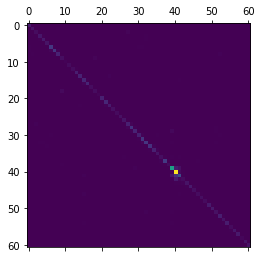

Classification Report
              precision    recall  f1-score   support

        ah_0       0.69      0.78      0.73     18732
        ah_1       0.74      0.69      0.72     15513
        ah_2       0.64      0.59      0.61     11269
        ao_0       0.79      0.81      0.80     14732
        ao_1       0.81      0.83      0.82     16593
        ao_2       0.82      0.83      0.82     12841
        ay_0       0.84      0.84      0.84     38703
        ay_1       0.89      0.81      0.85     37216
        ay_2       0.76      0.74      0.75     26225
        eh_0       0.52      0.63      0.57     11809
        eh_1       0.85      0.71      0.77      3333
        eh_2       0.78      0.77      0.78      7243
        ey_0       0.61      0.62      0.61      9276
        ey_1       0.80      0.88      0.84     19208
        ey_2       0.84      0.83      0.83     23634
         f_0       0.66      0.81      0.73     25993
         f_1       0.90      0.85      0.87     24580
     

In [14]:
model = load_model("nets/mspec_dyn_recognizer_adam.h5")
score = model.evaluate(X_test, Y_test, batch_size=128)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Y_pred = model.predict(X_test)
save_predictions(Y_test, Y_pred, 'mspec_dyn')
print('\nConfusion Matrix')
plt.matshow(confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)))
plt.show()
print('Classification Report')
print(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names=stateList))

## 3) Non-dynamic LMFCC as features

In [15]:
X = None; Y=None; X_val = None; Y_val = None; X_test = None; Y_test = None; model = None

# Load data
with np.load('datas/lmfcc_train_x_non_dynamic_reg.npz', allow_pickle=True) as data:
    X = data['lmfcc_x']
    Y = data['targets']
with np.load('datas/lmfcc_val_x_non_dynamic_reg.npz', allow_pickle=True) as data:
    X_val = data['lmfcc_x']
    Y_val = data['targets']
with np.load('datas/lmfcc_test_x_non_dynamic_reg.npz', allow_pickle=True) as data:
    X_test = data['lmfcc_x']
    Y_test = data['targets']

In [43]:
model = Sequential()
model.add(Dense(256, input_shape=(X.shape[1],), activation='relu') )
model.add(Dense(256, activation='relu'))
model.add(Dense(Y.shape[1], activation='sigmoid'))
opt = keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X, Y, epochs=15, batch_size=256, validation_data = (X_val, Y_val))
model.save("nets/lmfcc_non_dyn_recognizer_adam.h5")

Train on 1357194 samples, validate on 149863 samples
Epoch 1/15
1357194/1357194 [==============================] - 27s 20us/step - loss: 1.3234 - accuracy: 0.5920 - val_loss: 1.2380 - val_accuracy: 0.6149
Epoch 2/15
1357194/1357194 [==============================] - 26s 20us/step - loss: 1.1952 - accuracy: 0.6253 - val_loss: 1.1999 - val_accuracy: 0.6251
Epoch 3/15
1357194/1357194 [==============================] - 27s 20us/step - loss: 1.1613 - accuracy: 0.6343 - val_loss: 1.1806 - val_accuracy: 0.6298
Epoch 4/15
1357194/1357194 [==============================] - 27s 20us/step - loss: 1.1401 - accuracy: 0.6400 - val_loss: 1.1629 - val_accuracy: 0.6349
Epoch 5/15
1357194/1357194 [==============================] - 27s 20us/step - loss: 1.1238 - accuracy: 0.6445 - val_loss: 1.1540 - val_accuracy: 0.6369
Epoch 6/15
1357194/1357194 [==============================] - 27s 20us/step - loss: 1.1119 - accuracy: 0.6481 - val_loss: 1.1453 - val_accuracy: 0.6395
Epoch 7/15
1357194/1357194 [=======

1526682/1526682 [==============================] - 14s 9us/step
accuracy: 60.43%

Confusion Matrix


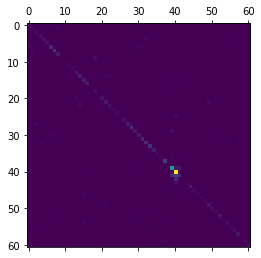

Classification Report
              precision    recall  f1-score   support

        ah_0       0.39      0.45      0.42     18732
        ah_1       0.35      0.32      0.33     15513
        ah_2       0.38      0.40      0.39     11269
        ao_0       0.64      0.50      0.56     14732
        ao_1       0.63      0.68      0.66     16593
        ao_2       0.57      0.64      0.60     12841
        ay_0       0.69      0.59      0.64     38703
        ay_1       0.74      0.83      0.78     37216
        ay_2       0.59      0.56      0.57     26225
        eh_0       0.31      0.05      0.09     11809
        eh_1       0.34      0.40      0.37      3333
        eh_2       0.47      0.59      0.52      7243
        ey_0       0.42      0.27      0.33      9276
        ey_1       0.57      0.71      0.63     19208
        ey_2       0.63      0.66      0.64     23634
         f_0       0.53      0.62      0.57     25993
         f_1       0.68      0.79      0.73     24580
     

In [16]:
model = load_model("nets/lmfcc_non_dyn_recognizer_adam.h5")
score = model.evaluate(X_test, Y_test, batch_size=128)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Y_pred = model.predict(X_test)
save_predictions(Y_test, Y_pred, 'lmfcc_non_dyn')
print('\nConfusion Matrix')
plt.matshow(confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)))
plt.show()
print('Classification Report')
print(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names=stateList))

## 4) Non-dynamic MSPEC as features

In [17]:
X = None; Y=None; X_val = None; Y_val = None; X_test = None; Y_test = None

# Load data
with np.load('datas/mspec_train_x_non_dynamic_reg.npz', allow_pickle=True) as data:
    X = data['mspec_x']
    Y = data['targets']
with np.load('datas/mspec_val_x_non_dynamic_reg.npz', allow_pickle=True) as data:
    X_val = data['mspec_x']
    Y_val = data['targets']
with np.load('datas/mspec_test_x_non_dynamic_reg.npz', allow_pickle=True) as data:
    X_test = data['mspec_x']
    Y_test = data['targets']

In [46]:
model = Sequential()
model.add(Dense(256, input_shape=(X.shape[1],), activation='relu') )
model.add(Dense(256, activation='relu'))
model.add(Dense(Y.shape[1], activation='sigmoid'))
opt = keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X, Y, epochs=15, batch_size=256, validation_data = (X_val, Y_val))
model.save("nets/mspec_non_dyn_recognizer_adam.h5")

Train on 1357194 samples, validate on 149863 samples
Epoch 1/15
1357194/1357194 [==============================] - 28s 21us/step - loss: 1.3665 - accuracy: 0.5797 - val_loss: 1.2478 - val_accuracy: 0.6127
Epoch 2/15
1357194/1357194 [==============================] - 28s 21us/step - loss: 1.1931 - accuracy: 0.6256 - val_loss: 1.1811 - val_accuracy: 0.6290
Epoch 3/15
1357194/1357194 [==============================] - 28s 21us/step - loss: 1.1443 - accuracy: 0.6394 - val_loss: 1.1699 - val_accuracy: 0.6314
Epoch 4/15
1357194/1357194 [==============================] - 28s 20us/step - loss: 1.1129 - accuracy: 0.6485 - val_loss: 1.1382 - val_accuracy: 0.6422
Epoch 5/15
1357194/1357194 [==============================] - 28s 21us/step - loss: 1.0897 - accuracy: 0.6551 - val_loss: 1.1159 - val_accuracy: 0.6473
Epoch 6/15
1357194/1357194 [==============================] - 28s 21us/step - loss: 1.0716 - accuracy: 0.6609 - val_loss: 1.1144 - val_accuracy: 0.6489
Epoch 7/15
1357194/1357194 [=======

1526682/1526682 [==============================] - 14s 9us/step
accuracy: 61.64%

Confusion Matrix


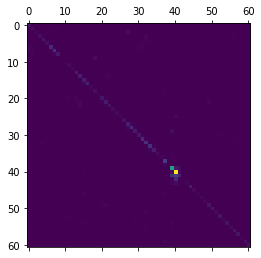

Classification Report
              precision    recall  f1-score   support

        ah_0       0.42      0.51      0.46     18732
        ah_1       0.36      0.46      0.41     15513
        ah_2       0.48      0.21      0.29     11269
        ao_0       0.67      0.52      0.59     14732
        ao_1       0.67      0.66      0.66     16593
        ao_2       0.68      0.56      0.62     12841
        ay_0       0.74      0.64      0.69     38703
        ay_1       0.80      0.73      0.76     37216
        ay_2       0.67      0.53      0.59     26225
        eh_0       0.30      0.07      0.11     11809
        eh_1       0.42      0.39      0.40      3333
        eh_2       0.41      0.71      0.52      7243
        ey_0       0.41      0.29      0.34      9276
        ey_1       0.57      0.79      0.66     19208
        ey_2       0.63      0.70      0.66     23634
         f_0       0.54      0.62      0.58     25993
         f_1       0.70      0.78      0.74     24580
     

In [18]:
model = load_model("nets/mspec_non_dyn_recognizer_adam.h5")
score = model.evaluate(X_test, Y_test, batch_size=128)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Y_pred = model.predict(X_test)
save_predictions(Y_test, Y_pred, 'mspec_non_dyn')
print('\nConfusion Matrix')
plt.matshow(confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)))
plt.show()
print('Classification Report')
print(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names=stateList))

# Detailed Evaluation

### Frame by frame at state level

In [19]:
def state_level_acc(Y_test_indexes,Y_pred_indexes):
    return sum(Y_test_indexes==Y_pred_indexes) / len(Y_test_indexes)



featuretypes = ['lmfcc_dyn','mspec_dyn','lmfcc_non_dyn','mspec_non_dyn']
for f in featuretypes:
    Y_test_indexes,Y_pred_indexes=load_predictions(f)
    frame_level_accuracy = state_level_acc(Y_test_indexes,Y_pred_indexes)
    print("The frame level accuracy for "+f+" features is:", frame_level_accuracy)

The frame level accuracy for lmfcc_dyn features is: 0.7754561853745574
The frame level accuracy for mspec_dyn features is: 0.7661562787797328
The frame level accuracy for lmfcc_non_dyn features is: 0.6043458952158995
The frame level accuracy for mspec_non_dyn features is: 0.616351014815135


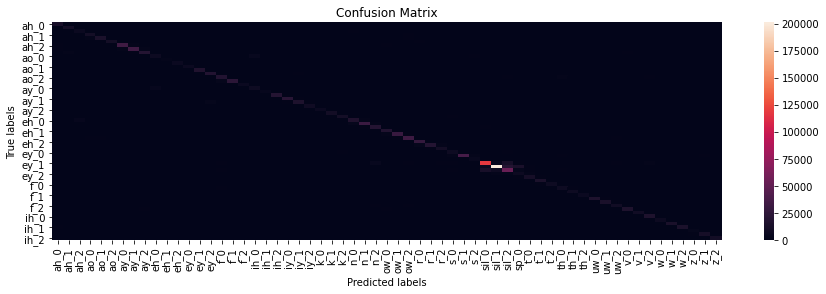

In [6]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

Y_test_indexes,Y_pred_indexes=load_predictions('lmfcc_dyn')
cm = confusion_matrix(Y_pred_indexes, Y_test_indexes)


import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(stateList); ax.yaxis.set_ticklabels(stateList);
# phones

### Frame by frame at the phoneme level

In [3]:
def phoneme_level_acc(Y_test_indexes,Y_pred_indexes):
    _,stateList,_ = pickle.load( open('saved_files/phoneHMM_states.pkl', 'rb'))
    
    sp_index = stateList.index('sp_0')
    phoneme_level_predictions = [] # True or False
    i = 0
    while True:
        if i >= len(Y_test_indexes): break
        if Y_test_indexes[i] == sp_index:
            phoneme_level_predictions.append(Y_pred_indexes[i]==Y_test_indexes[i])
            i+=1
        else:
            phoneme_level_predictions.append((Y_pred_indexes[i:i+3]==Y_test_indexes[i:i+3]).all())
            i+=3
    return sum(phoneme_level_predictions)/len(phoneme_level_predictions)




featuretypes = ['lmfcc_dyn','mspec_dyn','lmfcc_non_dyn','mspec_non_dyn']
for f in featuretypes:
    Y_test_indexes,Y_pred_indexes=load_predictions(f)
    phoneme_level_accuracy = phoneme_level_acc(Y_test_indexes,Y_pred_indexes)
    print("The phoneme level accuracy for "+f+" features is:", phoneme_level_accuracy)

The phoneme level accuracy for lmfcc_dyn features is: 0.6104584434352562
The phoneme level accuracy for mspec_dyn features is: 0.5976961530102152
The phoneme level accuracy for lmfcc_non_dyn features is: 0.4029349073618626
The phoneme level accuracy for mspec_non_dyn features is: 0.41665427424244156


In [49]:
def phoneme_predictions_builder(Y_test_indexes,Y_pred_indexes):
    _,stateList,_ = pickle.load( open('saved_files/phoneHMM_states.pkl', 'rb'))
    
    sp_index = stateList.index('sp_0')
    phoneme_level_predictions = [] # True or False
    i = 0
    phoneme_true = []
    phoneme_predictions = []
    
    while True:
        if i >= len(Y_test_indexes): break
        if Y_test_indexes[i] == sp_index:
            phoneme_true.append('sp')
            phoneme_predictions.append(stateList[Y_pred_indexes[i]].split('_')[0])
            i+=1
        else:
            phoneme_true.append(stateList[Y_test_indexes[i]].split('_')[0])
            phoneme_predictions.append(stateList[Y_test_indexes[i]].split('_')[0])
            i+=3
#     i = 0
#     while True:
#         if i >= len(Y_pred_indexes): break
#         if Y_pred_indexes[i] == sp_index:
#             phoneme_predictions.append('sp')
#             i+=1
#         else:
#             k = i+1
#             phon = stateList[Y_pred_indexes[i]].split('_')[0]
#             while k < len(Y_pred_indexes) and phon in stateList[Y_pred_indexes[k]]:
# #                 print(stateList[Y_pred_indexes[k]], phon)
#                 k=k+1
#             phoneme_predictions.append(phon)
#             i=k
    return phoneme_true, phoneme_predictions


1526682

according to this phoneme abstaction the accuracy is: 0.9650838681141019


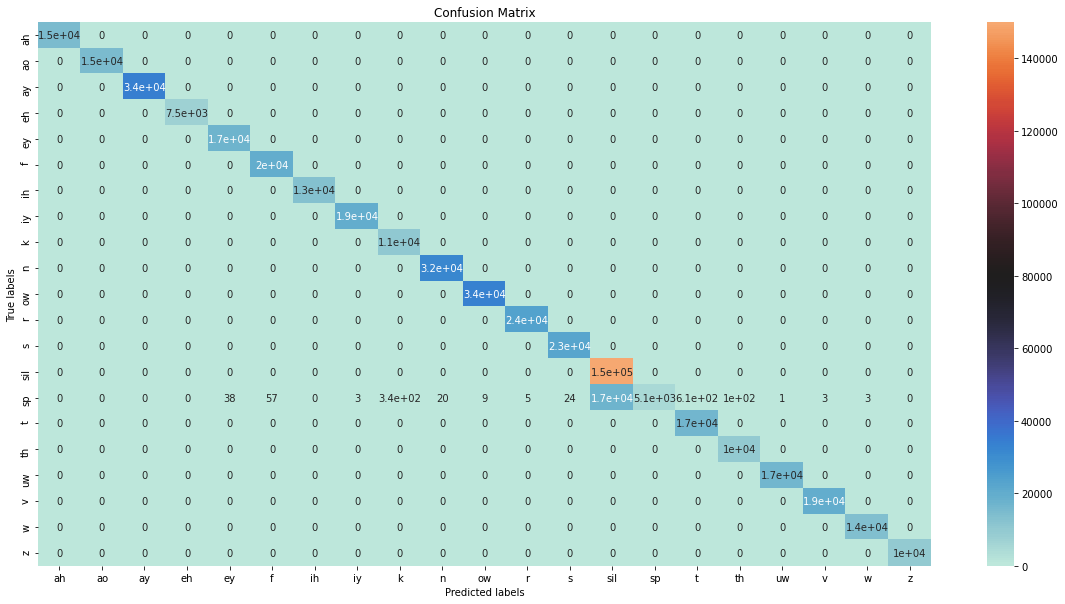

In [62]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  

Y_test_indexes,Y_pred_indexes=load_predictions('lmfcc_dyn')

# compute the true and predicted phonemes
phoneme_true, phoneme_predictions = phoneme_predictions_builder(Y_test_indexes,Y_pred_indexes)
phoneme_true = [phones.index(ph) for ph in phoneme_true]
phoneme_predictions = [phones.index(ph) for ph in phoneme_predictions]
acc = np.sum([ph1 == ph2 for ph1,ph2 in zip(phoneme_true, phoneme_predictions)])/ len(phoneme_true)
print("according to this phoneme abstaction the accuracy is:",acc )


plt.figure(figsize=(20,10))
ax= plt.subplot()
cm = confusion_matrix(phoneme_true, phoneme_predictions)
sns.heatmap(cm,center=80000,annot=True); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(phones); ax.yaxis.set_ticklabels(phones);


### Edit distance at state level

In [ ]:
import editdistance

def state_level_edit_distance(Y_test_indexes, Y_pred_indexes):
    # transcript pred_states (i.e. ox1 ox2 ox3 -> ox)
    Y_pred_transcripted = []
    i = 0
    while True:
        if i >= len(Y_pred_indexes): break
        tmp = Y_pred_indexes[i]
        while i < len(Y_pred_indexes) and tmp==Y_pred_indexes[i]:
            i+=1
        Y_pred_transcripted.append(tmp)

    # transcript test_states
    Y_test_transcripted = []
    i = 0
    while True:
        if i >= len(Y_test_indexes): break
        tmp = Y_test_indexes[i]
        while i < len(Y_test_indexes) and tmp==Y_test_indexes[i]:
            i+=1
        Y_test_transcripted.append(tmp)
        
    return editdistance.eval(Y_pred_transcripted, Y_test_transcripted)


featuretypes = ['lmfcc_dyn','mspec_dyn','lmfcc_non_dyn','mspec_non_dyn']
for f in featuretypes:
    Y_test_indexes,Y_pred_indexes = load_predictions(f)
    edit_distance = state_level_edit_distance(Y_test_indexes, Y_pred_indexes)
    print("The state level edit distance for "+f+" features is:",edit_distance)

### Edit distance at phoneme level

In [ ]:
import editdistance
def phoneme_level_edit_distance(Y_test_indexes, Y_pred_indexes):
    nstates, stateList, phones= pickle.load( open('saved_files/phoneHMM_states.pkl', 'rb'))
   
    # merge frames from same state for the predicted frames
    Y_pred_phonemes = []
    i = 0
    while True:
        if i >= len(Y_pred_indexes): break
        tmp = phones.index(stateList[Y_pred_indexes[i]].split('_')[0])
        while i < len(Y_pred_indexes) and tmp==phones.index(stateList[Y_pred_indexes[i]].split('_')[0]):
            i+=1
        Y_pred_phonemes.append(tmp)
        
    # merge frames from same state for the test frames  
    Y_test_phonemes = []
    i = 0
    while True:
        if i >= len(Y_test_indexes): break
        tmp = phones.index(stateList[Y_test_indexes[i]].split('_')[0])
        while i < len(Y_test_indexes) and tmp==phones.index(stateList[Y_test_indexes[i]].split('_')[0]):
            i+=1
        Y_test_phonemes.append(tmp)
        
    return editdistance.eval(Y_pred_phonemes, Y_test_phonemes)


featuretypes = ['lmfcc_dyn','mspec_dyn','lmfcc_non_dyn','mspec_non_dyn']
f = featuretypes[0]
for f in featuretypes:
    Y_test_indexes,Y_pred_indexes = load_predictions(f)
    edit_distance = phoneme_level_edit_distance(Y_test_indexes, Y_pred_indexes)
    print("The phoneme level edit distance for "+f+" features is:",edit_distance)
